# Analysis Processed Slocum Glider-AD2CP Data: RU29 2020

In [1]:
# Imports
import scipy.interpolate as interp
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
#sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
#sys.path.insert(0,'/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/analysis/')
sys.path.insert(0,'../src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [2]:
ds_id = 'ru29-20200908T1623-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
variables2 = ['depth', 'latitude', 'longitude', 'time', 'temperature', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf.columns = variables2


## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

## Format time
gdf.time = pd.to_datetime(gdf.time.values).tz_localize(None).values

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,temperature,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.00000,18.175290,-64.802942,2020-09-08 16:23:40.150,0.0000,0.00000,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,NaN
1,0.00000,18.175290,-64.802942,2020-09-08 16:23:47.430,0.0000,0.00000,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,NaN
2,NaN,18.175290,-64.802942,2020-09-08 16:23:47.560,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,1.80293
3,NaN,18.175290,-64.802942,2020-09-08 16:24:48.430,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,1.80293
4,NaN,18.176045,-64.804093,2020-09-08 16:25:14.450,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5087216,0.18886,18.139090,-64.784373,2020-11-12 07:31:32.760,27.6073,5.43973,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN
5087217,0.18886,18.139090,-64.784373,2020-11-12 07:31:34.770,27.6072,5.43980,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN
5087218,0.14910,18.139090,-64.784373,2020-11-12 07:31:36.790,27.6093,5.43990,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN
5087219,0.15904,18.139090,-64.784373,2020-11-12 07:31:38.800,27.6093,5.43993,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN


## Step 2: Load processed AD2CP data

In [3]:
path = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Processed/"
#path = "/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/2020_Processed_Velocity_Profiles/"
files = np.sort(glob.glob(path+'*.csv'))

df = pd.concat(map(pd.read_csv, files))

df

,Unnamed: 0,inversion_u,inversion_v,inversion_depth,start_lon,start_lat,end_lon,end_lat,start_tm,end_tm,obs_per_bin
0,0,-0.223676,0.145671,5.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,614.0
1,1,-0.217123,0.148768,15.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,6420.0
2,2,-0.218543,0.153485,25.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,5644.0
3,3,-0.217000,0.121160,35.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,3421.0
4,4,-0.225147,0.132482,45.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,2393.0
...,...,...,...,...,...,...,...,...,...,...,...
94,94,-0.138960,-0.127398,945.0,-64.800935,17.857937,-64.799647,17.827635,2020-10-08T08:07:10.76Z,2020-10-08T11:09:50.52Z,NaN
95,95,-0.132397,-0.125714,955.0,-64.800935,17.857937,-64.799647,17.827635,2020-10-08T08:07:10.76Z,2020-10-08T11:09:50.52Z,NaN
96,96,-0.128342,-0.120690,965.0,-64.800935,17.857937,-64.799647,17.827635,2020-10-08T08:07:10.76Z,2020-10-08T11:09:50.52Z,NaN
97,97,-0.139163,-0.112944,975.0,-64.800935,17.857937,-64.799647,17.827635,2020-10-08T08:07:10.76Z,2020-10-08T11:09:50.52Z,NaN


In [6]:
dz = np.diff(df.inversion_depth)[0]
inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2020 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
ds

<xarray.Dataset>
Dimensions:     (depth: 99, time: 242)
Coordinates:
  * time        (time) datetime64[ns] 2020-10-02T04:20:23.550000 ... 2020-11-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 955.0 965.0 975.0 985.0
Data variables:
    u_grid      (depth, time) float64 -0.1726 -0.132 -0.2237 ... nan nan nan
    v_grid      (depth, time) float64 0.0999 0.04632 0.1457 ... nan nan nan
    latitude    (time) float64 18.03 18.05 18.07 18.1 ... 18.04 18.01 17.98
    longitude   (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.8
    start_lat   (time) float64 18.01 18.04 18.06 18.09 ... 18.06 18.03 18.0
    start_lon   (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.79
    end_lat     (time) float64 18.04 18.06 18.09 18.11 ... 18.03 18.0 17.97
    end_lon     (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.8
    start_time  (time) datetime64[ns] 2020-10-02T01:15:52.840000 ... 2020-11-...
    end_time    (time) datetime64[ns] 2020-10-02T04:20:23.550000 ... 2020-11-...
Attributes:
    description:  Master/combined RU29 2020 AD2CP least-squares inversion vel...

## Now load the shear method results

In [98]:
dz = 10

path = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Processed_shear_{}_meter_vertical_resoultion/".format(dz)



files = np.sort(glob.glob(path+'*.csv'))
shear_df = pd.concat(map(pd.read_csv, files))


shear_depth         = np.arange(np.min(shear_df.bin_new_shear),np.max(shear_df.bin_new_shear)+dz,dz)
shear_time          = np.empty(len(files))
shear_time[:]       = np.NaN
shear_time          = shear_time.astype(pd.Timestamp)
shear_start_time    = np.empty(len(files))
shear_start_time[:] = np.NaN
shear_start_time    = shear_time.astype(pd.Timestamp)
shear_end_time      = np.empty(len(files))
shear_end_time[:]   = np.NaN
shear_end_time      = shear_time.astype(pd.Timestamp)
shear_lat           = np.empty(len(files))
shear_lat[:]        = np.NaN
shear_lon           = np.empty(len(files))
shear_lon[:]        = np.NaN
shear_start_lat     = np.empty(len(files))
shear_start_lat[:]  = np.NaN
shear_start_lon     = np.empty(len(files))
shear_start_lon[:]  = np.NaN
shear_end_lat       = np.empty(len(files))
shear_end_lat[:]    = np.NaN
shear_end_lon       = np.empty(len(files))
shear_end_lon[:]    = np.NaN
u_grid = np.empty((len(shear_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(shear_depth),len(files)))
v_grid[:] = np.NaN
obs_per_bin = np.empty((len(shear_depth),len(files)))
obs_per_bin[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    shear_df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(shear_df.U_shear_method.values)),x] = shear_df.U_shear_method.values
    v_grid[np.arange(0,len(shear_df.V_shear_method.values)),x] = shear_df.V_shear_method.values
    obs_per_bin[np.arange(0,len(shear_df.obs_per_bin_shear.values)),x] = shear_df.obs_per_bin_shear.values

    
    shear_start_time[x] = pd.to_datetime(shear_df.start_tm[0]).tz_localize(None)
    shear_end_time[x] = pd.to_datetime(shear_df.end_tm[0]).tz_localize(None)
    mid_time = shear_end_time[x]-shear_start_time[x]
    
    shear_time[x] = shear_start_time[x]+mid_time

    shear_start_lat[x] = shear_df.start_lat[0]
    shear_start_lon[x] = shear_df.start_lon[0]
    shear_end_lat[x]   = shear_df.end_lat[0]
    shear_end_lon[x]   = shear_df.end_lon[0]
    ## Lat/lon mid point
    shear_lat[x]   = (shear_df.start_lat[0]+shear_df.end_lat[0])/2
    shear_lon[x]   = (shear_df.start_lon[0]+shear_df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
shear_ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        
        obs_per_bin = (["depth", "time"], obs_per_bin),
        
        latitude   = (["time"], shear_lat),
        longitude  = (["time"], shear_lon),
        start_lat  = (["time"], shear_start_lat),
        start_lon  = (["time"], shear_start_lon),
        end_lat    = (["time"], shear_end_lat),
        end_lon    = (["time"], shear_end_lon),
        start_time = (["time"], shear_start_time),
        end_time   = (["time"], shear_end_time)
    ),
    coords=dict(
        time  = shear_time,
        depth = shear_depth
    ),
    attrs=dict(description="Master/combined RU29 2020 Nortek AD2CP shear method velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
shear_ds = shear_ds.sortby(shear_ds.time)
shear_ds




<xarray.Dataset>
Dimensions:      (depth: 98, time: 242)
Coordinates:
  * time         (time) datetime64[ns] 2020-10-02T04:20:23.550000 ... 2020-11...
  * depth        (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid       (depth, time) float64 -0.2699 -0.26 -0.2027 ... nan nan nan
    v_grid       (depth, time) float64 -0.07031 -0.0361 0.01029 ... nan nan nan
    obs_per_bin  (depth, time) float64 360.0 545.0 614.0 513.0 ... nan nan nan
    latitude     (time) float64 18.03 18.05 18.07 18.1 ... 18.04 18.01 17.98
    longitude    (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.8
    start_lat    (time) float64 18.01 18.04 18.06 18.09 ... 18.06 18.03 18.0
    start_lon    (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.79
    end_lat      (time) float64 18.04 18.06 18.09 18.11 ... 18.03 18.0 17.97
    end_lon      (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.8
    start_time   (time) datetime64[ns] 2020-10-02T01:15:52.840000 ... 2020-11...
    end_time     (time) datetime64[ns] 2020-10-02T04:20:23.550000 ... 2020-11...
Attributes:
    description:  Master/combined RU29 2020 Nortek AD2CP shear method velocit...

# Plot individual profiles from the two methods and save them to make a movie

## First EW velocity

In [99]:
for x in np.arange(0,len(ds.time)):

    fig = plt.figure(figsize=(6,8))
    fig.patch.set_facecolor('white')
    plt.plot(ds.u_grid[:,x].values,ds.depth, color='tab:orange', linewidth=3, label='Inversion Method')
    plt.plot(shear_ds.u_grid[:,x].values,shear_ds.depth, color='tab:blue', linewidth=3, label='Shear Method')
    plt.ylim((1000,-1))
    plt.xlim((-0.5,0.5))
    plt.legend(loc='lower right',prop={'size': 12})
    plt.title('dz = {} meters\n{}\n{}'.format(dz, ds.time.values[x],shear_ds.time.values[x]))
    plt.ylabel('Depth [m]')
    plt.xlabel('EW Velocity [m/s]')

    plot_path_name = '/home/jg1200/Figures/RU29/RU29_2020/Inversion_Shear_Method_Comparison_Plots_EW_dz_{}/profile_{}.png'.format(dz,x)
    plt.savefig(plot_path_name,dpi=150)
    plt.close()


## Now NS velocity

In [ ]:
for x in np.arange(0,len(ds.time)):

    fig = plt.figure(figsize=(6,8))
    fig.patch.set_facecolor('white')
    plt.plot(ds.v_grid[:,x].values,ds.depth, color='tab:orange', linewidth=3, label='Inversion Method')
    plt.plot(shear_ds.v_grid[:,x].values,shear_ds.depth, color='tab:blue', linewidth=3, label='Shear Method')
    plt.ylim((1000,-1))
    plt.xlim((-0.5,0.5))
    plt.legend(loc='lower right',prop={'size': 12})
    plt.title('dz = {} meters\n{}\n{}'.format(dz, ds.time.values[x],shear_ds.time.values[x]))
    plt.ylabel('Depth [m]')
    plt.xlabel('NS Velocity [m/s]')

    plot_path_name = '/home/jg1200/Figures/RU29/RU29_2020/Inversion_Shear_Method_Comparison_Plots_NS_dz_{}/profile_{}.png'.format(dz,x)
    plt.savefig(plot_path_name,dpi=150)
    plt.close()


## Section Timing

In [11]:
sect_times1 = pd.read_csv('/home/jg1200/Data/GliderData/RU29/anagada_section_times.csv')
#sect_times1 = pd.read_csv('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/anagada_section_times.csv')
sect_times1.starttime = np.array(sect_times1.starttime,dtype=np.datetime64)
sect_times1.endtime = np.array(sect_times1.endtime,dtype=np.datetime64)
## This is the OG
sect_times = sect_times1.iloc[7:-1,:]
sect_times


,section_number,starttime,endtime
7,7,2020-10-15 09:07:30,2020-10-17 00:31:58
8,8,2020-10-17 00:31:58,2020-10-18 13:53:20
9,9,2020-10-18 13:53:20,2020-10-20 06:44:54
10,10,2020-10-20 06:44:54,2020-10-21 17:10:48
11,11,2020-10-21 17:10:48,2020-10-23 07:00:58
12,12,2020-10-23 07:00:58,2020-10-24 18:42:06
13,13,2020-10-24 18:42:06,2020-10-26 10:57:09
14,14,2020-10-26 10:57:09,2020-10-27 21:53:33
15,15,2020-10-27 21:53:33,2020-10-29 15:06:27
16,16,2020-10-29 15:06:27,2020-10-31 03:11:10


## Loop to pull out DACs and stick in a dataframe

In [12]:
vx = np.empty(len(start_times))
vx[:] = np.NaN
vy = np.empty(len(start_times))
vy[:] = np.NaN
vx_start_lon = np.empty(len(start_times))
vx_start_lon[:] = np.NaN
vx_start_lat = np.empty(len(start_times))
vx_start_lat[:] = np.NaN
vx_end_lon = np.empty(len(start_times))
vx_end_lon[:] = np.NaN
vx_end_lat = np.empty(len(start_times))
vx_end_lat[:] = np.NaN
vx_start_tm = np.empty(len(start_times),dtype=pd.Timestamp)
vx_end_tm = np.empty(len(start_times),dtype=pd.Timestamp)


for x in np.arange(0,len(start_times)):

    ## Subset glider df to one segment
    subsetgdf = gdf[(gdf.time >= start_times2[x]) & (gdf.time <= end_times2[x])]
    ## Pull out last non-NaN DAC
    ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
    
    ## Check if there is a DAC, if not continue onto next segment.
    if len(ind) > 0:
        vx[x]          = subsetgdf.m_water_vx.iloc[ind[-1]]
        vy[x]         = subsetgdf.m_water_vy.iloc[ind[-1]]
        
        ## Pull out last non-NaN lat/lon
        ind1         = np.argwhere(np.isnan(subsetgdf.longitude).ravel()==False).flatten()   
        vx_start_lon[x] = subsetgdf.longitude.iloc[ind1[0]]
        vx_start_lat[x] = subsetgdf.latitude.iloc[ind1[0]]
        vx_end_lon[x]   = subsetgdf.longitude.iloc[ind1[-1]]
        vx_end_lat[x]   = subsetgdf.latitude.iloc[ind1[-1]]
        ## Not using the index here because I want the segment start and end times
        vx_start_tm[x]  = subsetgdf.time.iloc[0]
        vx_end_tm[x]    = subsetgdf.time.iloc[-1]


In [13]:
data = {'vx': vx, 'vy': vy, 'start_lon': vx_start_lon, 'start_lat': vx_start_lat, 'end_lon': vx_end_lon,
       'end_lat': vx_end_lat, 'start_time': vx_start_tm, 'end_time': vx_end_tm}

DACdf = pd.DataFrame(data)
DACdf


,vx,vy,start_lon,start_lat,end_lon,end_lat,start_time,end_time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...
1076,-0.039627,0.010190,-64.786398,18.168172,-64.788425,18.163332,2020-11-16 11:05:42.450,2020-11-16 12:25:10.040
1077,-0.039627,0.010190,-64.788425,18.163332,-64.788425,18.163332,2020-11-16 12:30:35.990,2020-11-16 12:32:36.860
1078,-0.122072,0.085841,-64.788425,18.163332,-64.789908,18.163992,2020-11-16 12:32:47.510,2020-11-16 13:00:22.810
1079,-0.025824,0.027190,-64.784288,18.139775,-64.784373,18.139090,2020-11-12 04:10:58.940,2020-11-12 07:20:50.870


## Subset to just transects

## Glider data first, then velocity dataset

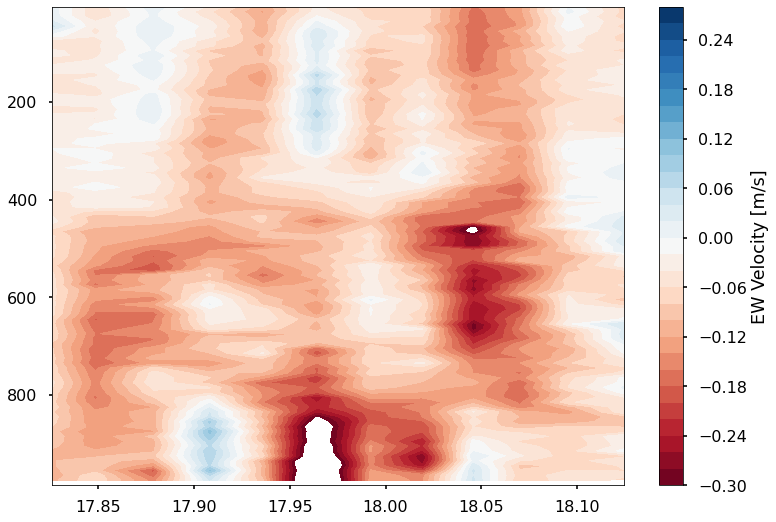

In [49]:
start = 2
end = 2
gdf_sect = gdf.loc[(gdf.time >= sect_times.starttime.values[start]) & (gdf.time <= sect_times.endtime.values[end])]
ds_sect = ds.sel(time=slice(sect_times.starttime.values[start], sect_times.endtime.values[end]))
plt.contourf(ds_sect.latitude,ds_sect.depth,ds_sect.u_grid,levels=np.arange(-0.3,0.3,0.02) ,cmap='RdBu')
plt.gca().invert_yaxis()
plt.colorbar(label='EW Velocity [m/s]')

## Calculate complex velocity variance

### First filter out profiles that don't make it to 1000 meters

In [21]:
uvelnanind = np.sum(np.isnan(ds.u_grid.values),axis=0)
vvelnanind = np.sum(np.isnan(ds.v_grid.values),axis=0)
lowuvelnanind = np.where(uvelnanind>10)[0]
lowvvelnanind = np.where(vvelnanind>10)[0]

ds.u_grid[:,lowuvelnanind] = np.NaN
ds.v_grid[:,lowvvelnanind] = np.NaN

In [22]:
complex_vel = np.empty((len(ds.depth),len(ds.time)),dtype = 'complex_')
complex_vel[:] = np.NaN

for x in np.arange(0,len(ds.start_time)):
    ds2 = ds.sel(time=slice(ds.start_time[x],ds.end_time[x]))
    gdf2 = gdf.loc[(gdf.time >= ds2.start_time.values[0]) & (gdf.time <= ds2.end_time.values[-1])]
    
    mean_heading = np.nanmean(gdf2.m_heading)
    
    #along_vel = ds2.u_grid.values*np.sin(mean_heading) + ds2.v_grid.values*np.cos(mean_heading)
    #cross_vel = ds2.u_grid.values*np.cos(mean_heading) + ds2.v_grid.values*np.sin(mean_heading)
        
    complex_vel[:,x] = np.array(list(map(complex,ds2.u_grid.values,ds2.v_grid.values)))
    #complex_vel[:,x] = np.array(list(map(complex,cross_vel,along_vel)))

    

(0.0, 0.02)

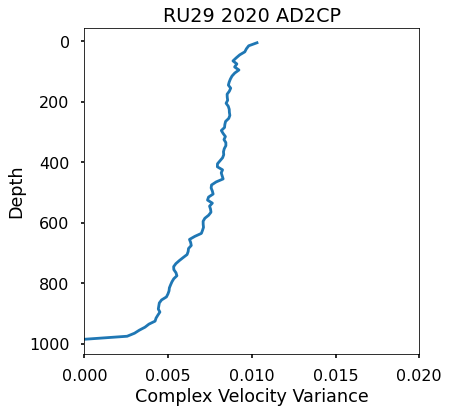

In [23]:
complex_vel_var = np.nanvar(complex_vel,axis=1)

plt.figure(figsize=(6,6))
plt.plot(complex_vel_var,ds.depth)
plt.gca().invert_yaxis()
plt.ylabel('Depth')
plt.xlabel('Complex Velocity Variance')
plt.title('RU29 2020 AD2CP')
plt.xlim(0,0.02)

## Find minimum variance point

(0.0, 0.02)

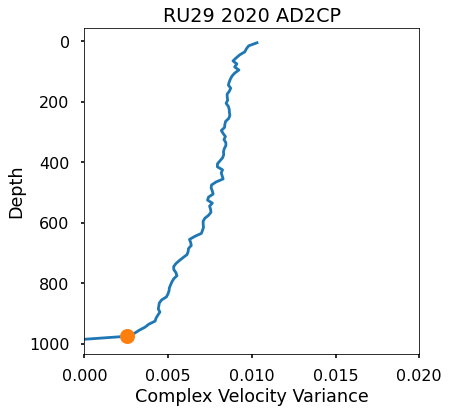

In [24]:
index = np.where(complex_vel_var == np.nanmin(complex_vel_var[0:-1]))[0][0]

plt.figure(figsize=(6,6))
plt.plot(complex_vel_var,ds.depth)
plt.plot(complex_vel_var[index],ds.depth[index], '.',color='tab:orange',markersize=30)
plt.gca().invert_yaxis()
plt.ylabel('Depth')
plt.xlabel('Complex Velocity Variance')
plt.title('RU29 2020 AD2CP')
plt.xlim(0,0.02)

## Load just science data now

In [25]:
ds_id = 'ru29-20200908T1623-profile-sci-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'salinity', 'temperature','density','source_file', 'profile_id','m_pitch']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables


## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

## Format time
gdf.time = pd.to_datetime(gdf.time.values).tz_localize(None).values

#gdf.density = gdf.density+1000

gdf


,depth,latitude,longitude,time,salinity,temperature,density,source_file,profile_id,m_pitch
0,0.139160,18.176980,-64.805536,2020-09-08 16:26:37,34.925755,29.7325,1021.76230,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
1,NaN,18.176990,-64.805546,2020-09-08 16:26:38,NaN,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
2,0.159039,18.177001,-64.805555,2020-09-08 16:26:39,34.923603,29.7288,1021.76210,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
3,NaN,18.177012,-64.805565,2020-09-08 16:26:40,NaN,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
4,0.159039,18.177022,-64.805575,2020-09-08 16:26:41,34.925000,29.7280,1021.76337,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
...,...,...,...,...,...,...,...,...,...,...
4951791,0.188860,18.163975,-64.789906,2020-11-16 12:58:58,34.743874,28.0090,1022.20080,ru29-2020-315-0-76-mbd(04470076),1599583881,NaN
4951792,0.238559,18.163982,-64.789903,2020-11-16 12:59:00,34.743202,28.0097,1022.20026,ru29-2020-315-0-76-mbd(04470076),1599583881,NaN
4951793,0.159040,18.163988,-64.789900,2020-11-16 12:59:02,34.744360,28.0074,1022.20154,ru29-2020-315-0-76-mbd(04470076),1599583881,NaN
4951794,NaN,18.163988,-64.789900,2020-11-16 12:59:02,NaN,NaN,NaN,ru29-2020-315-0-76-mbd(04470076),1599583881,NaN


In [26]:
y=1
subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
gdf2 = gdf.loc[(gdf.time >= subset_ds_sect.start_time.values[0]) & (gdf.time <= subset_ds_sect.end_time.values[-1])]

subset_ds_sect
    

<xarray.Dataset>
Dimensions:     (depth: 99, time: 12)
Coordinates:
  * time        (time) datetime64[ns] 2020-10-17T01:13:26.030000 ... 2020-10-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 955.0 965.0 975.0 985.0
Data variables:
    u_grid      (depth, time) float64 -0.04088 0.04975 -0.04696 ... nan nan nan
    v_grid      (depth, time) float64 0.04323 -0.00445 -0.01232 ... nan nan nan
    latitude    (time) float64 18.14 18.14 18.11 18.08 ... 17.89 17.86 17.84
    longitude   (time) float64 -64.79 -64.79 -64.79 -64.79 ... -64.8 -64.8 -64.8
    start_lat   (time) float64 18.12 18.16 18.13 18.1 ... 17.91 17.88 17.85
    start_lon   (time) float64 -64.79 -64.78 -64.79 -64.79 ... -64.8 -64.8 -64.8
    end_lat     (time) float64 18.16 18.13 18.1 18.06 ... 17.88 17.85 17.82
    end_lon     (time) float64 -64.78 -64.79 -64.79 -64.79 ... -64.8 -64.8 -64.8
    start_time  (time) datetime64[ns] 2020-10-16T22:04:23.630000 ... 2020-10-...
    end_time    (time) datetime64[ns] 2020-10-17T01:13:26.030000 ... 2020-10-...
Attributes:
    description:  Master/combined RU29 2020 AD2CP least-squares inversion vel...

In [27]:
DACdf2 = DACdf.loc[(DACdf.start_time >= subset_ds_sect.start_time.values[0]) & (DACdf.end_time <= subset_ds_sect.end_time.values[-1])]

DACdf2

,vx,vy,start_lon,start_lat,end_lon,end_lat,start_time,end_time
546,-0.062697,0.008334,-64.792203,18.124088,-64.784182,18.155028,2020-10-16 22:04:23.630,2020-10-17 01:13:26.030
547,-0.062697,0.008334,-64.784182,18.155028,-64.784182,18.155028,2020-10-17 01:22:16.700,2020-10-17 01:24:03.130
548,-0.052941,0.015617,-64.784182,18.155028,-64.787272,18.127808,2020-10-17 01:24:17.920,2020-10-17 04:30:51.120
549,-0.052941,0.015617,-64.787272,18.127808,-64.787272,18.127808,2020-10-17 04:39:28.010,2020-10-17 04:41:14.300
550,-0.042021,0.020390,-64.787272,18.127808,-64.787828,18.096457,2020-10-17 04:41:24.020,2020-10-17 07:44:10.270
551,-0.042021,0.020390,-64.787828,18.096457,-64.787828,18.096457,2020-10-17 07:53:01.030,2020-10-17 07:54:47.070
553,-0.047366,0.013327,-64.787828,18.096457,-64.790445,18.064335,2020-10-17 07:54:57.220,2020-10-17 10:58:09.670
554,-0.047366,0.013327,-64.790445,18.064335,-64.790445,18.064335,2020-10-17 11:08:12.320,2020-10-17 11:09:59.010
555,-0.089567,-0.005772,-64.790445,18.064335,-64.795752,18.031192,2020-10-17 11:10:08.600,2020-10-17 14:12:27.140
556,-0.089567,-0.005772,-64.795752,18.031192,-64.795752,18.031192,2020-10-17 14:21:31.000,2020-10-17 14:23:16.750


## Do grid interpolation on a finer scale (both latitudinally and depth wise) for better thermal wind estimate

In [28]:
# What do we want dz here to be
griddepth = np.arange(0,1001,dz)
lat_grid = np.arange(17.8,18.16,0.05)
lon_grid = np.repeat(-64.80,8) # Just make it -64.80

X, Y, Z = np.meshgrid(lon_grid, lat_grid, griddepth)


gridtemp = np.empty((len(griddepth),len(lat_grid),15))
gridtemp[:] = np.NaN
gridsalinity = np.empty((len(griddepth),len(lat_grid),15))
gridsalinity[:] = np.NaN
griddensity = np.empty((len(griddepth),len(lat_grid),15))
griddensity[:] = np.NaN
gridvx = np.empty((len(lat_grid),15))
gridvx[:] = np.NaN


for y in np.arange(0,15):

    ## ADCP
    subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
    gdf2 = gdf.loc[(gdf.time >= subset_ds_sect.start_time.values[0]) & (gdf.time <= subset_ds_sect.end_time.values[-1])]    
    DACdf2 = DACdf.loc[(DACdf.start_time >= subset_ds_sect.start_time.values[0]) & (DACdf.end_time <= subset_ds_sect.end_time.values[-1])]

    profile_IDs = np.unique(gdf2.profile_id)
    profileid_start_index = np.empty(len(profile_IDs),dtype='int')
    profileid_end_index = np.empty(len(profile_IDs),dtype='int')
    
    for x in np.arange(0,len(profile_IDs)):
        profileid_start_index[x] = np.where(gdf2.profile_id == profile_IDs[x])[0][0]
        profileid_end_index[x] = np.where(gdf2.profile_id == profile_IDs[x])[0][-1]
    
    tgriddensity = np.empty((len(griddepth),len(profile_IDs)))
    tgriddensity[:] = np.NaN
    tgridtemp = np.empty((len(griddepth),len(profile_IDs)))
    tgridtemp[:] = np.NaN
    tgridsalinity = np.empty((len(griddepth),len(profile_IDs)))
    tgridsalinity[:] = np.NaN
    profile_lats = np.empty((len(profile_IDs)))
    profile_lats[:] = np.NaN
    profile_lons = np.empty((len(profile_IDs)))
    profile_lons[:] = np.NaN
    
    for x in np.arange(0,len(profile_IDs)):
        tgriddensity[:,x] = interp.griddata(gdf2.depth.values[profileid_start_index[x]:profileid_end_index[x]],gdf2.density.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        tgridtemp[:,x] = interp.griddata(gdf2.depth.values[profileid_start_index[x]:profileid_end_index[x]],gdf2.temperature.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        tgridsalinity[:,x] = interp.griddata(gdf2.depth.values[profileid_start_index[x]:profileid_end_index[x]],gdf2.salinity.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        profile_lats[x] = gdf2.latitude.values[profileid_start_index[x]]
        profile_lons[x] = gdf2.longitude.values[profileid_start_index[x]]

    ## Drop columns of all nan
    tgridtemp = tgridtemp[:,~np.isnan(tgridtemp).all(axis=0)]
    tgridsalinity = tgridsalinity[:,~np.isnan(tgridsalinity).all(axis=0)]
    tgriddensity = tgriddensity[:,~np.isnan(tgriddensity).all(axis=0)]
    
    gridvx[:,y] = interp.griddata(DACdf2.start_lat.values, DACdf2.vx.values, lat_grid, method='nearest')

    for x in np.arange(0,len(griddepth)):
        gridtemp[x,:,y] = interp.griddata(profile_lats, tgridtemp[x,:], lat_grid, method='nearest')
        gridsalinity[x,:,y] = interp.griddata(profile_lats, tgridsalinity[x,:], lat_grid, method='nearest')
        griddensity[x,:,y] = interp.griddata(profile_lats, tgriddensity[x,:], lat_grid, method='nearest')

totgriddensity = np.nanmean(griddensity,axis=2)




/tmp/ipykernel_7544/3793264823.py:64: RuntimeWarning: Mean of empty slice
  totgriddensity = np.nanmean(griddensity,axis=2)


/tmp/ipykernel_7544/3371976348.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,totgriddensity,cmap=cmo.dense)


Text(0.5, 1.0, 'Deployment Mean Density')

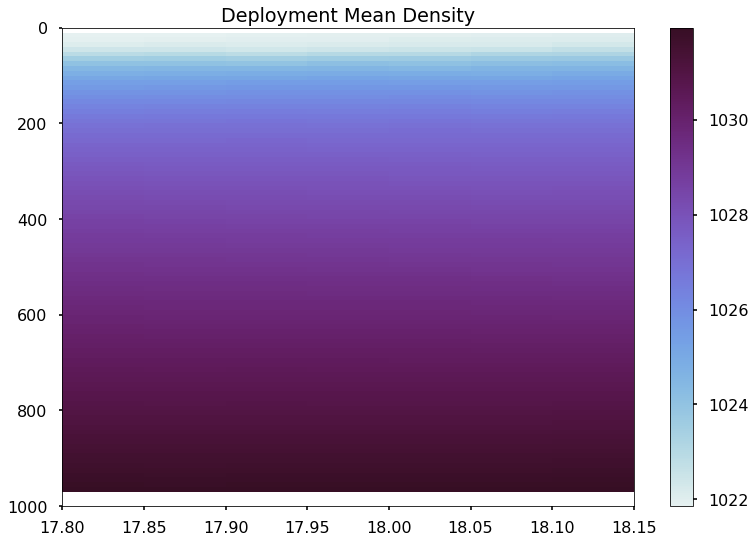

In [29]:
plt.pcolormesh(lat_grid,griddepth,totgriddensity,cmap=cmo.dense)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Deployment Mean Density')

/tmp/ipykernel_7544/3294384636.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,griddensity[:,:,1],cmap=cmo.dense)


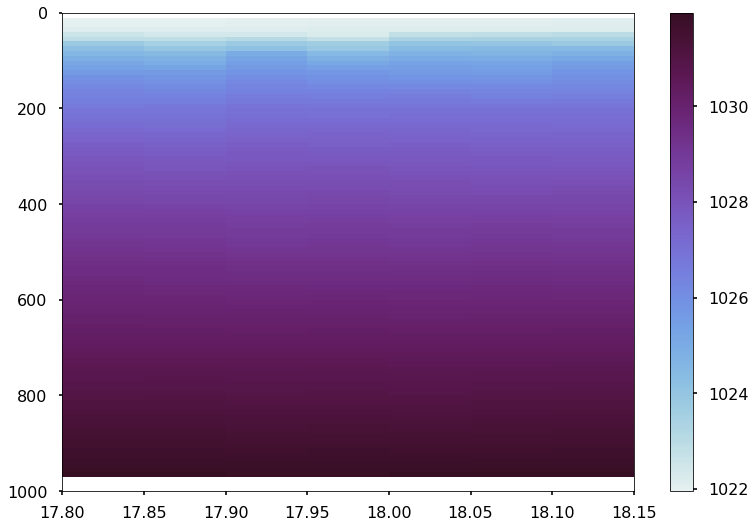

In [30]:
plt.pcolormesh(lat_grid,griddepth,griddensity[:,:,1],cmap=cmo.dense)
plt.gca().invert_yaxis()
plt.colorbar()

## Calculate $\frac{\partial \rho}{\partial y}$

In [31]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(lat_grid[0])
lon1 = radians(lon_grid[0])
lat2 = radians(lat_grid[1])
lon2 = radians(lon_grid[0])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c *1000 # in meters

distance

5561.491661480293

In [32]:
#d_rho_dy = np.diff(griddensity,axis=1)/distance
d_rho_dy = np.gradient(griddensity,distance,axis=1)

tot_d_rho_dy = np.gradient(totgriddensity,distance,axis=1)

/tmp/ipykernel_7544/1447371370.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,tot_d_rho_dy)


Text(0.5, 1.0, 'Deployment Averaged')

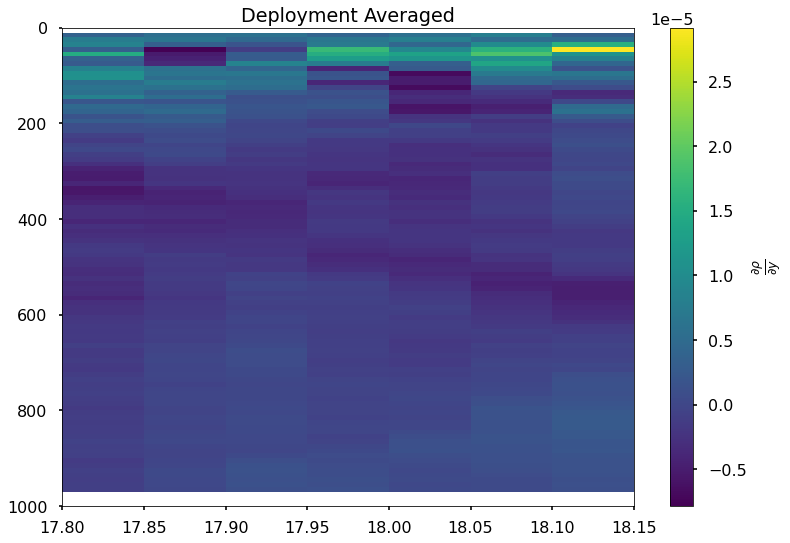

In [33]:
plt.pcolormesh(lat_grid,griddepth,tot_d_rho_dy)
plt.colorbar(label = r'$\frac{\partial \rho}{\partial y}$')
plt.gca().invert_yaxis()
plt.title('Deployment Averaged')


/tmp/ipykernel_7544/596945473.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,d_rho_dy[:,:,3])


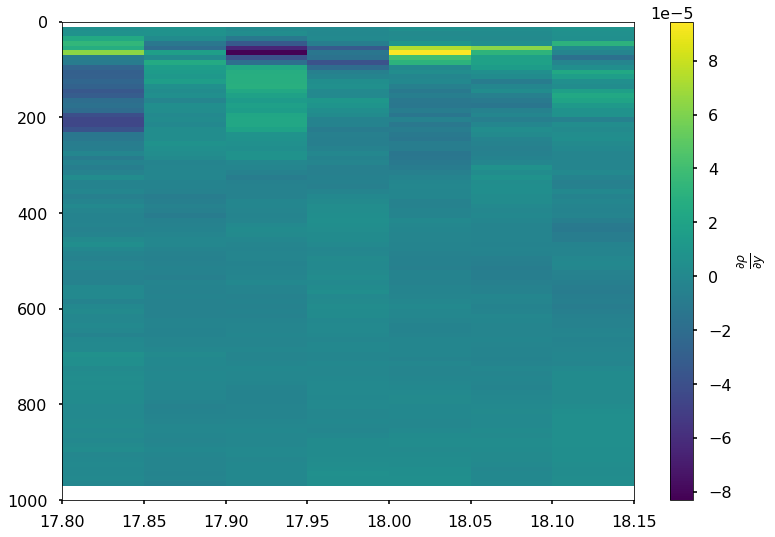

In [34]:
plt.pcolormesh(lat_grid,griddepth,d_rho_dy[:,:,3])
plt.colorbar(label = r'$\frac{\partial \rho}{\partial y}$')
plt.gca().invert_yaxis()

# get $\frac{\partial u}{\partial z}$

ok, now we have all the components of the right hand side to give us how the velocity changes with depth :

$$
\frac{g}{\rho f}\frac{\partial \rho}{\partial y}
$$

In [35]:
import seawater as sw

CF = sw.extras.f(ds.start_lat.mean())

g = sw.eos80.g(ds.start_lat.mean(), 0)

therm_wind = (1/CF)*(g/1027)*d_rho_dy
tot_therm_wind = (1/CF)*(g/1027)*tot_d_rho_dy

/tmp/ipykernel_7544/2750907907.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,tot_therm_wind,cmap='RdBu')


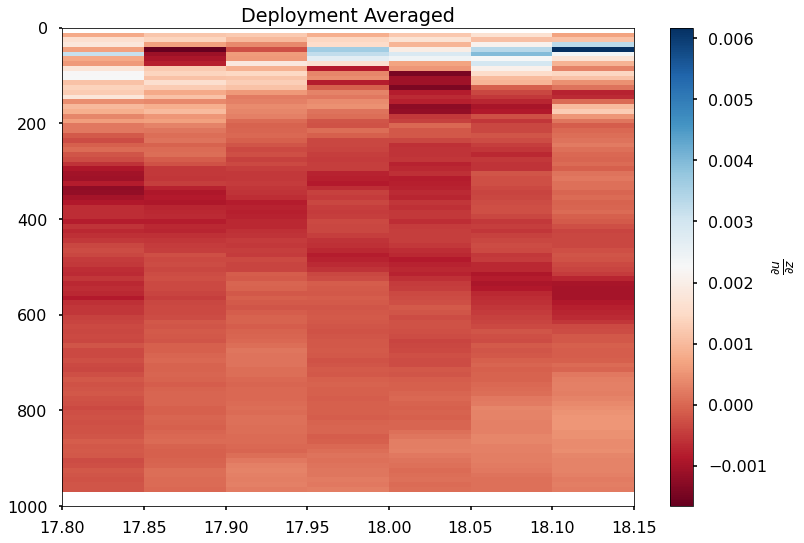

In [36]:
plt.pcolormesh(lat_grid,griddepth,tot_therm_wind,cmap='RdBu')
plt.title('Deployment Averaged')
plt.gca().invert_yaxis()
plt.colorbar(label = r'$\frac{\partial u}{\partial z}$')

/tmp/ipykernel_7544/4279662054.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,therm_wind[:,:,2],cmap='RdBu')


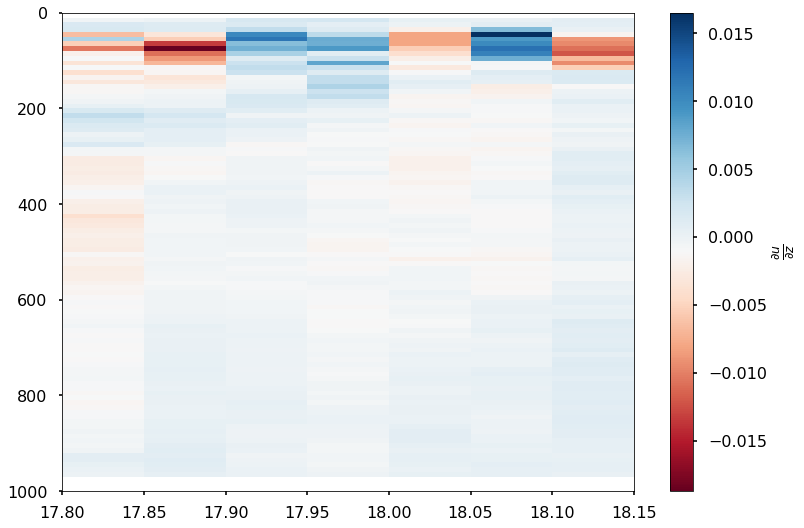

In [37]:
plt.pcolormesh(lat_grid,griddepth,therm_wind[:,:,2],cmap='RdBu')
plt.gca().invert_yaxis()
plt.colorbar(label = r'$\frac{\partial u}{\partial z}$')

/tmp/ipykernel_7544/4117987637.py:1: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(lat_grid,griddepth,np.nanmean(therm_wind,axis=2),cmap='RdBu',vmin=-0.01,vmax=0.01)
/tmp/ipykernel_7544/4117987637.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,np.nanmean(therm_wind,axis=2),cmap='RdBu',vmin=-0.01,vmax=0.01)


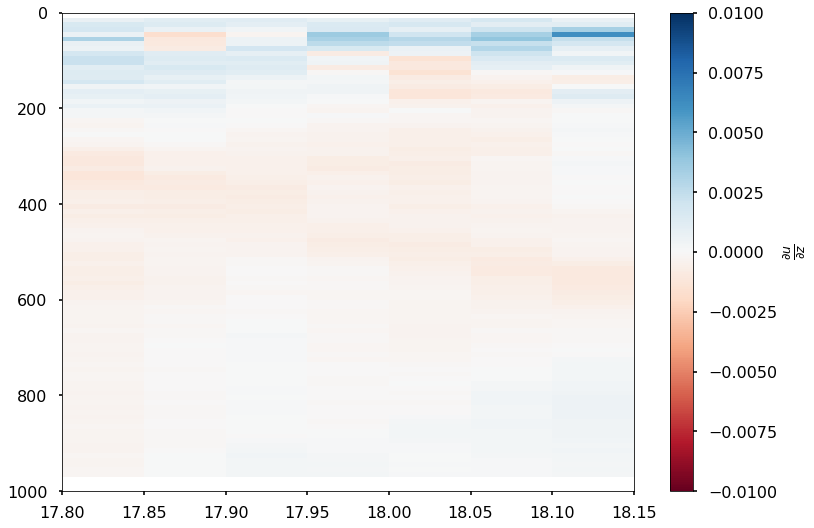

In [38]:
plt.pcolormesh(lat_grid,griddepth,np.nanmean(therm_wind,axis=2),cmap='RdBu',vmin=-0.01,vmax=0.01)
plt.gca().invert_yaxis()
plt.colorbar(label = r'$\frac{\partial u}{\partial z}$')

# Integrate vertically to get $u$

So far we have $\frac{\partial u}{\partial z}$, or how velocity changes with depth. But what  we would really like to know is the total velocity $u$. 

We can integrate the shear to get this!

$$
u = \int \frac{du}{dz}dz
$$


or actually each little step in $v$ looks like this (just re arrainging the equation):

$$
\Delta u = \frac{\Delta u}{\Delta z} * \Delta z
$$

if you sub in the thermal wind equation it looks like this:

$$
\Delta u = \frac{-g}{\rho f}\frac{\Delta \rho}{\Delta y} * \Delta z
$$

and if we want the total $u$ we can sum up all the little $\Delta u$'s from the water column to get a profile of $u$

This actually just gives us a `relative geostrophic velocity` something we will have to reference to get the absolute velocity

In [39]:
from scipy import integrate


# replace nan with zeros for integration
therm_wind[np.where(np.isnan(therm_wind) ==True)] = 0
tot_therm_wind[np.where(np.isnan(tot_therm_wind) ==True)] = 0

# flip to integrate from bottom, then flip back
dz = np.mean(np.diff(griddepth))

rel_Vg = integrate.cumtrapz(therm_wind[::-1,:,:], dx=dz, initial=0, axis=0)[::-1,:,:]
tot_rel_Vg = integrate.cumtrapz(tot_therm_wind[::-1,:], dx=dz, initial=0, axis=0)[::-1,:]


Text(0.5, 1.0, 'Deployment Averaged Relative Geostrophic Velocity')

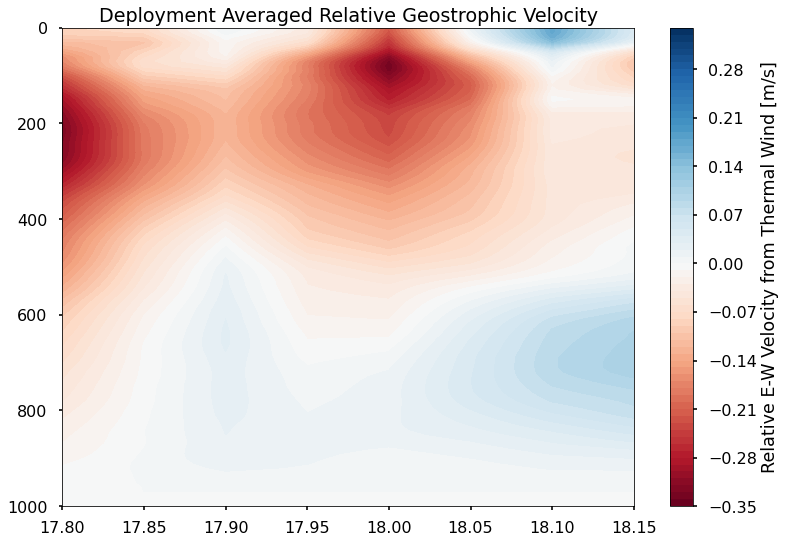

In [40]:
#plt.pcolormesh(lat_grid,griddepth,tot_rel_Vg,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.contourf(lat_grid,griddepth,tot_rel_Vg,cmap='RdBu',levels=np.arange(-0.35,0.35,0.01))
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()
plt.title('Deployment Averaged Relative Geostrophic Velocity')

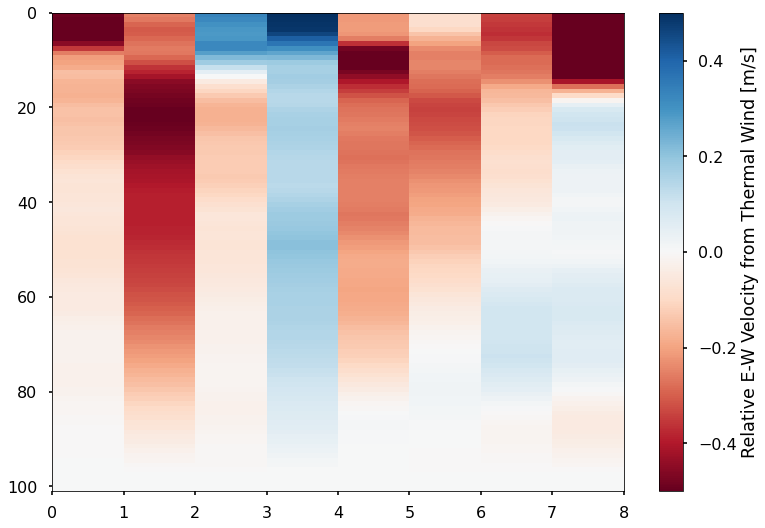

In [41]:
#plt.contourf(rel_Vg[:,:,7],cmap='RdBu',levels=np.arange(-0.5,0.5,0.025))
plt.pcolormesh(rel_Vg[:,:,7],cmap='RdBu',vmin=-0.5,vmax=0.5)
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

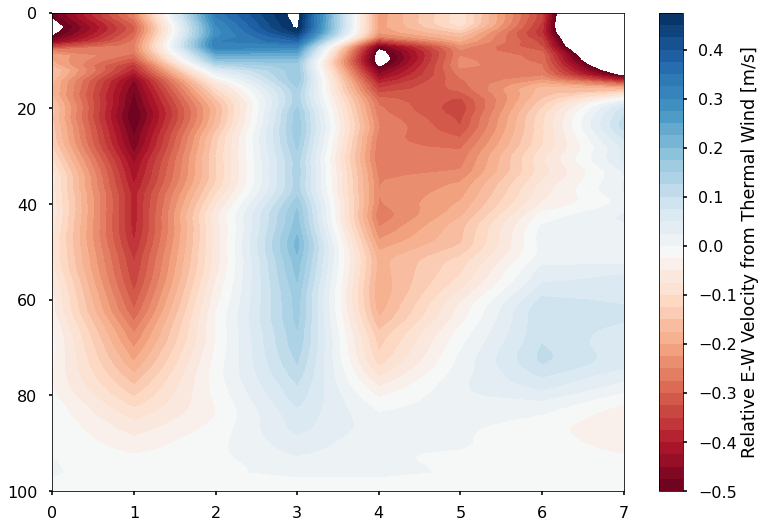

In [42]:
plt.contourf(rel_Vg[:,:,7],cmap='RdBu',levels=np.arange(-0.5,0.5,0.025))
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

In [43]:
mean_rel_Vg = np.nanmean(rel_Vg,axis=2)

In [44]:
mean_rel_Vg.shape

(101, 8)

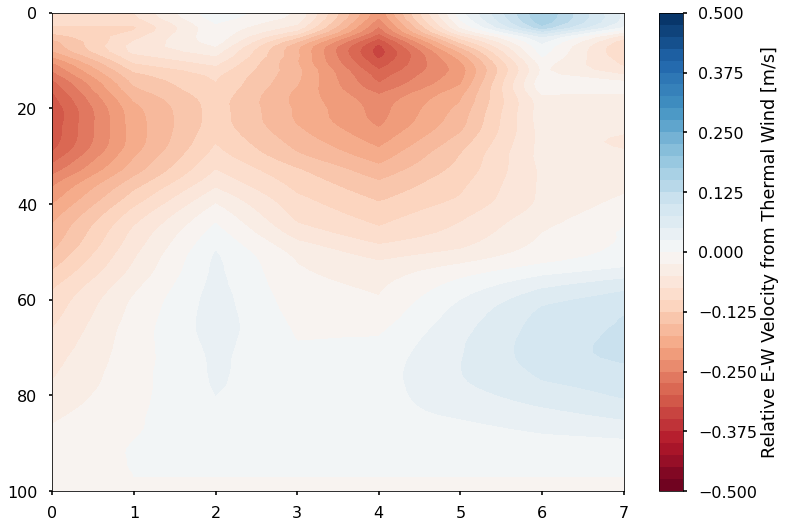

In [45]:
plt.contourf(mean_rel_Vg,cmap='RdBu',levels=np.arange(-0.5,0.51,0.025))
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

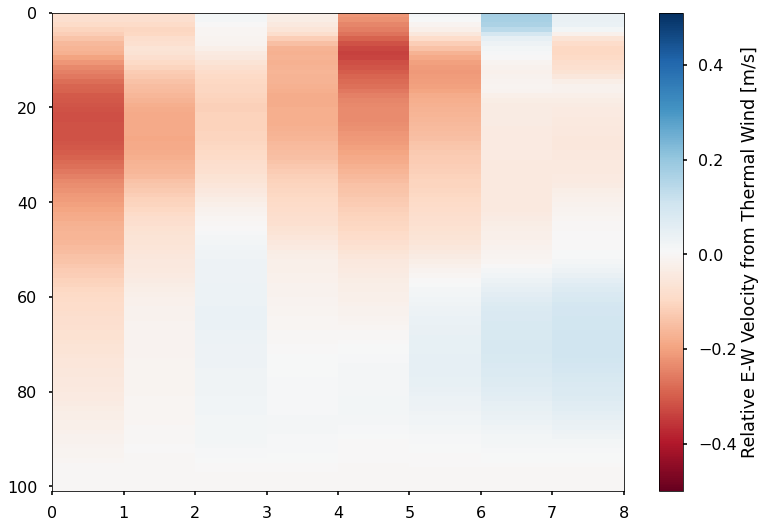

In [46]:
plt.pcolormesh(mean_rel_Vg,cmap='RdBu',vmin=-0.5,vmax=0.51)
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

# add the reference velocity

$$
V_{abs}(x,z) = V_{rel}(x,z) + V_{ref}(x)
$$

The reference, $V_{ref}$, is calculated from the DAC ($V_{dac}$) such that:

$$
V_{ref}(x) = V_{dac} - \frac{1}{h}\int_h V_{g}(x,z)dz
$$

In [47]:
vref = gridvx - np.nanmean(rel_Vg,axis=0)

Vgeo = rel_Vg + vref

mean_Vgeo = np.nanmean(Vgeo,axis=2)


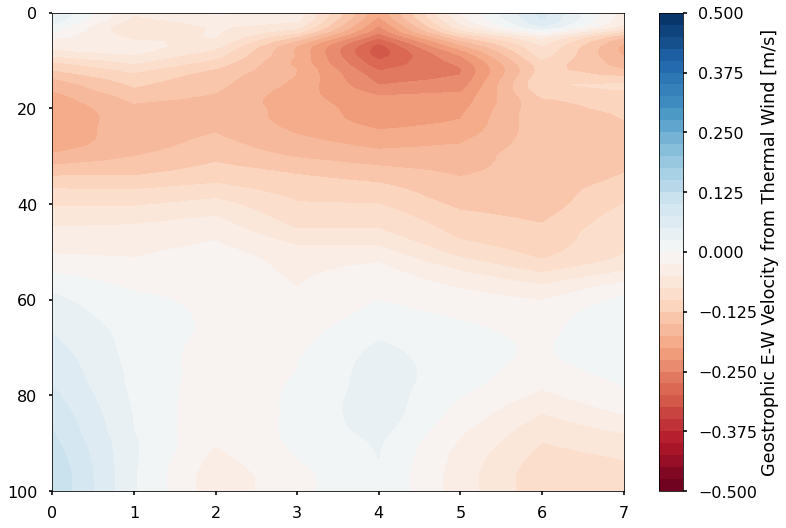

In [48]:
plt.contourf(mean_Vgeo,cmap='RdBu',levels=np.arange(-0.5,0.51,0.025))
#plt.pcolormesh(mean_Vgeo,cmap='RdBu')
plt.colorbar(label='Geostrophic E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

## Calculate Transport based off geostrophic velocity

In [49]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(lat_grid[0])
lon1 = radians(lon_grid[0])
lat2 = radians(lat_grid[1])
lon2 = radians(lon_grid[0])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c *1000 # in meters

distance

5561.491661480293

In [50]:
geo_transport_gridu = np.empty(Vgeo.shape[2])
geo_transport_gridu[:] = np.NaN

dz = np.mean(np.diff(griddepth))

for x in np.arange(0,Vgeo.shape[2]):
    geo_transport_gridu[x] = (np.nansum(Vgeo[:,:,x]*dz*distance))/(10**6)
    
## No loop needed for the deployment averaged transport
tot_geo_transport_gridu = (np.nansum(tot_rel_Vg[:,:]*dz*distance))/(10**6)
tot_geo_transport_gridu

-2.391533891369924

Text(0.5, 1.0, 'E-W Transport from Geostrophic Velocity\nRU29 October 2020')

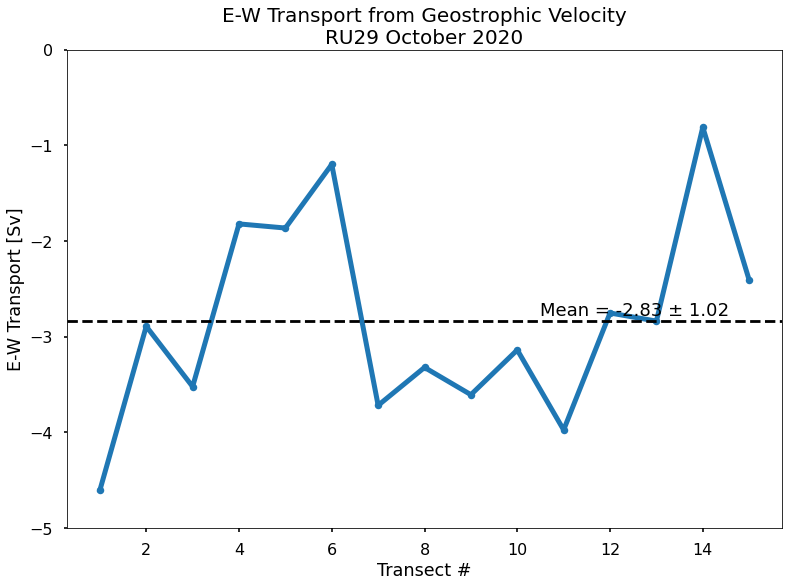

In [51]:
plt.plot(np.arange(1,16),geo_transport_gridu, linewidth=5,color='tab:blue')
plt.plot(np.arange(1,16),geo_transport_gridu, '.',color='tab:blue',markersize=15)
plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-5,0)
plt.axhline(y=np.nanmean(geo_transport_gridu), color='k', linestyle='--')
plt.text(10.5, np.nanmean(geo_transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(geo_transport_gridu),2),np.round(np.nanstd(geo_transport_gridu),2)),fontsize=18);
plt.title('E-W Transport from Geostrophic Velocity\nRU29 October 2020',fontsize=20)


## Interpolation Grid

In [55]:
## Coarser lat grid 
lat_grid = np.arange(17.8,18.16,0.05)

#lon_grid
lon_grid = np.repeat(-64.80,8) # Just make it -64.80
## Make grid
X, Y, Z = np.meshgrid(lon_grid, lat_grid, inversion_depth)

## This works for one transect
gridvelu = np.empty((len(inversion_depth),len(lat_grid),15))
gridvelu[:] = np.NaN
gridvelv = np.empty((len(inversion_depth),len(lat_grid),15))
gridvelv[:] = np.NaN
gridtemp = np.empty((len(inversion_depth),len(lat_grid),15))
gridtemp[:] = np.NaN
gridsalinity = np.empty((len(inversion_depth),len(lat_grid),15))
gridsalinity[:] = np.NaN
griddensity = np.empty((len(inversion_depth),len(lat_grid),15))
griddensity[:] = np.NaN


for y in np.arange(0,15):

    ## ADCP
    subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
    gdf2 = gdf.loc[(gdf.time >= subset_ds_sect.start_time.values[0]) & (gdf.time <= subset_ds_sect.end_time.values[-1])]

    ## Pull out glider segments by source file name
    segnames = np.unique(gdf2.source_file)
    segstart_index = np.empty((len(segnames)),dtype='int')
    segend_index   = np.empty((len(segnames)),dtype='int')

    for x in np.arange(0,len(segnames)):
        segstart_index[x] = np.where(gdf2.source_file == segnames[x])[0][0]
        segend_index[x] = np.where(gdf2.source_file == segnames[x])[0][-1]


    tgridtemp = np.empty((len(inversion_depth),len(segnames)))
    tgridtemp[:] = np.NaN
    tgridsalinity = np.empty((len(inversion_depth),len(segnames)))
    tgridsalinity[:] = np.NaN
    tgriddensity = np.empty((len(inversion_depth),len(segnames)))
    tgriddensity[:] = np.NaN


    for x in np.arange(0,len(segnames)):
        ## Only proceed is we have depth data deeper than 10 meters indicating we're not sitting at the surface
        if np.nanmax(gdf2.depth.values[segstart_index[x]:segend_index[x]]) > 10:

            tgridtemp[:,x] = interp.griddata(gdf2.depth.values[segstart_index[x]:segend_index[x]],gdf2.temperature.values[segstart_index[x]:segend_index[x]],inversion_depth)
            tgridsalinity[:,x] = interp.griddata(gdf2.depth.values[segstart_index[x]:segend_index[x]],gdf2.salinity.values[segstart_index[x]:segend_index[x]],inversion_depth)
            tgriddensity[:,x] = interp.griddata(gdf2.depth.values[segstart_index[x]:segend_index[x]],gdf2.density.values[segstart_index[x]:segend_index[x]],inversion_depth)


    ## Drop columns of all nan
    tgridtemp = tgridtemp[:,~np.isnan(tgridtemp).all(axis=0)]
    tgridsalinity = tgridsalinity[:,~np.isnan(tgridsalinity).all(axis=0)]
    tgriddensity = tgriddensity[:,~np.isnan(tgriddensity).all(axis=0)]
    

    for x in np.arange(0,len(inversion_depth)):
        gridvelu[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, subset_ds_sect.u_grid.values[x,:], lat_grid, method='nearest')
        gridvelv[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, subset_ds_sect.v_grid.values[x,:], lat_grid, method='nearest')
        gridtemp[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, tgridtemp[x,:], lat_grid, method='nearest')
        gridsalinity[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, tgridsalinity[x,:], lat_grid, method='nearest')
        griddensity[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, tgriddensity[x,:], lat_grid, method='nearest')
        
        
        
meangridu = np.nanmean(gridvelu,axis=2)
meangridv = np.nanmean(gridvelv,axis=2)
stdgridu  = np.nanstd(gridvelu, axis=2)
stdgridv  = np.nanstd(gridvelv, axis=2)

/tmp/ipykernel_7544/3092593861.py:71: RuntimeWarning: Mean of empty slice
  meangridu = np.nanmean(gridvelu,axis=2)
/tmp/ipykernel_7544/3092593861.py:72: RuntimeWarning: Mean of empty slice
  meangridv = np.nanmean(gridvelv,axis=2)
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Do shear method transport calculation seperately because the depth grid is one less

In [76]:
## Coarser lat grid 
lat_grid = np.arange(17.8,18.16,0.05)

#lon_grid
lon_grid = np.repeat(-64.80,8) # Just make it -64.80
## Make grid
inversion_depth = shear_ds.depth.values
X, Y, Z = np.meshgrid(lon_grid, lat_grid, inversion_depth)

## This works for one transect
shear_gridvelu = np.empty((len(inversion_depth),len(lat_grid),15))
shear_gridvelu[:] = np.NaN
shear_gridvelv = np.empty((len(inversion_depth),len(lat_grid),15))
shear_gridvelv[:] = np.NaN


for y in np.arange(0,15):

    ## ADCP
    subset_shear_ds = shear_ds.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))

    for x in np.arange(0,len(inversion_depth)):
        shear_gridvelv[x,:,y] = interp.griddata(subset_shear_ds.latitude.values, subset_shear_ds.v_grid.values[x,:], lat_grid, method='nearest')
        shear_gridvelu[x,:,y] = interp.griddata(subset_shear_ds.latitude.values, subset_shear_ds.u_grid.values[x,:], lat_grid, method='nearest')

        
shear_meangridu = np.nanmean(shear_gridvelu,axis=2)
shear_meangridv = np.nanmean(shear_gridvelv,axis=2)
shear_stdgridu  = np.nanstd(shear_gridvelu, axis=2)
shear_stdgridv  = np.nanstd(shear_gridvelv, axis=2)

/tmp/ipykernel_7544/2842638463.py:27: RuntimeWarning: Mean of empty slice
  shear_meangridu = np.nanmean(shear_gridvelu,axis=2)
/tmp/ipykernel_7544/2842638463.py:28: RuntimeWarning: Mean of empty slice
  shear_meangridv = np.nanmean(shear_gridvelv,axis=2)
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


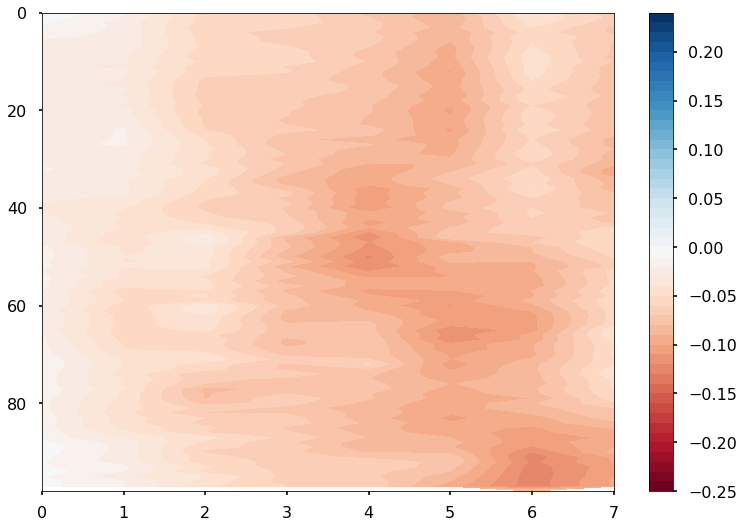

In [52]:
plt.contourf(meangridu,cmap='RdBu',levels=np.arange(-0.25,0.25,0.01))
plt.colorbar()
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Temporal Mean E-W Velocity RU29 October 2020')

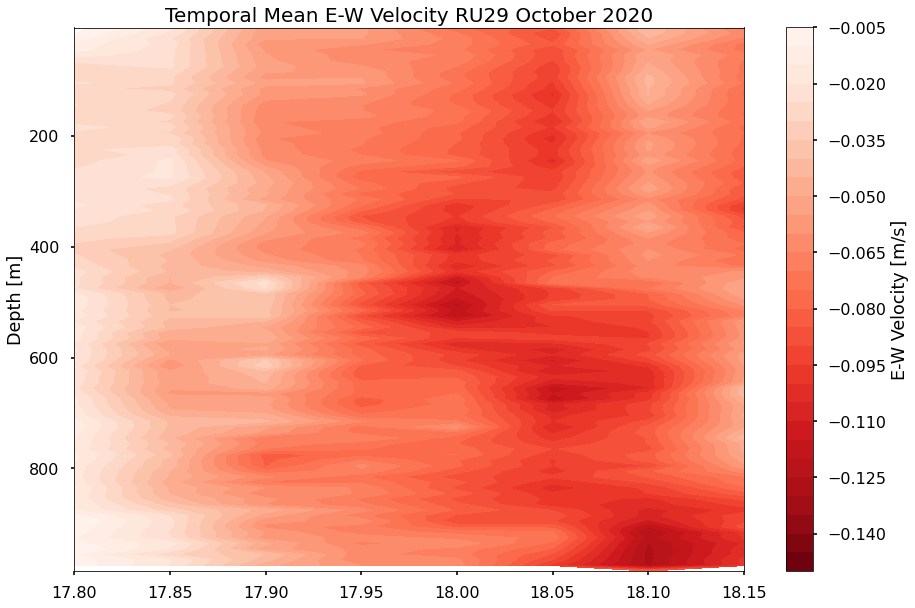

In [71]:
from scipy.ndimage.filters import gaussian_filter

#sigma = 1.25 # this depends on how noisy your data is, play with it!
#data = gaussian_filter(meangridu, sigma)


plt.figure(figsize=(15,10))
plt.contourf(lat_grid,inversion_depth,meangridu,cmap='Reds_r',levels=np.arange(-0.15, 0, 0.005))
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]');
#contours = plt.contour(lat_grid,inversion_depth,data,levels=[-0.08,-0.06,-0.04], colors='black',linewidths=0.6)
#plt.clabel(contours, inline=True, fontsize=14)
plt.ylabel('Depth [m]')
plt.title('Temporal Mean E-W Velocity RU29 October 2020',fontsize=20)

# plt.contourf(lat_grid,inversion_depth,meangridu,cmap=cmo.speed)#levels=np.arange(-0.131, 0, 0.01))
# plt.gca().invert_yaxis()
# plt.colorbar(label='RU29 AD2CP E-W Velocity [m/s]');
# plt.ylabel('Depth [m]')
# plt.title('Temporal Mean E-W Velocity')

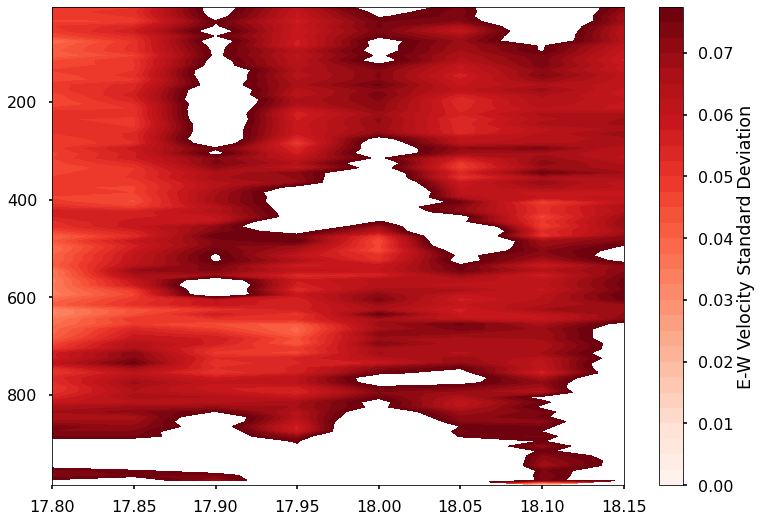

In [55]:
plt.contourf(lat_grid,inversion_depth,stdgridu,cmap='Reds',levels=np.arange(0, 0.08, 0.0025))
plt.colorbar(label='E-W Velocity Standard Deviation')
plt.gca().invert_yaxis()
#plt.ylim(250,0)

Text(0.5, 1.0, 'Temporal Mean N-S Velocity RU29 October 2020')

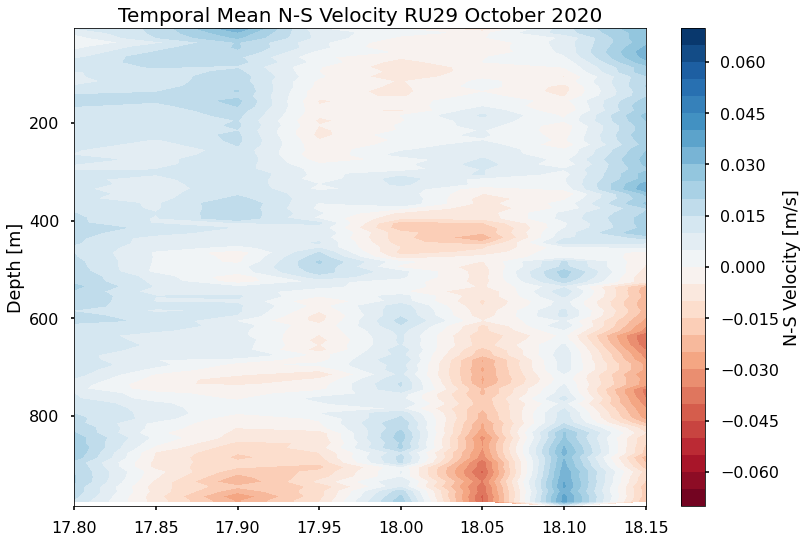

In [56]:
plt.contourf(lat_grid,inversion_depth,meangridv,cmap='RdBu',levels=np.arange(-0.07, 0.07, 0.005))
plt.gca().invert_yaxis()
#plt.ylim(250,0)
plt.colorbar(label='N-S Velocity [m/s]');
plt.ylabel('Depth [m]')
plt.title('Temporal Mean N-S Velocity RU29 October 2020',fontsize=20)

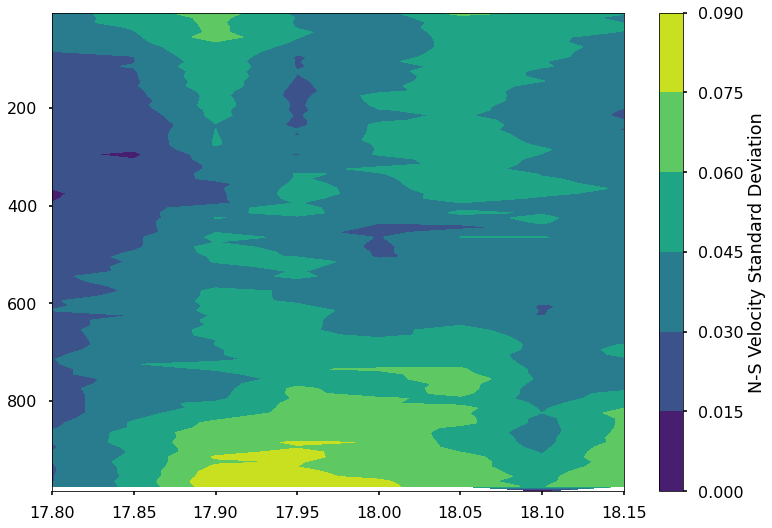

In [57]:
plt.contourf(lat_grid,inversion_depth,stdgridv)#levels=np.arange(0, 0.076, 0.005))
plt.colorbar(label='N-S Velocity Standard Deviation')
plt.gca().invert_yaxis()
#plt.ylim(250,0)

## Calculate some Transport!

In [58]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(lat_grid[0])
lon1 = radians(lon_grid[0])
lat2 = radians(lat_grid[1])
lon2 = radians(lon_grid[0])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c *1000 # in meters

distance

5561.491661480293

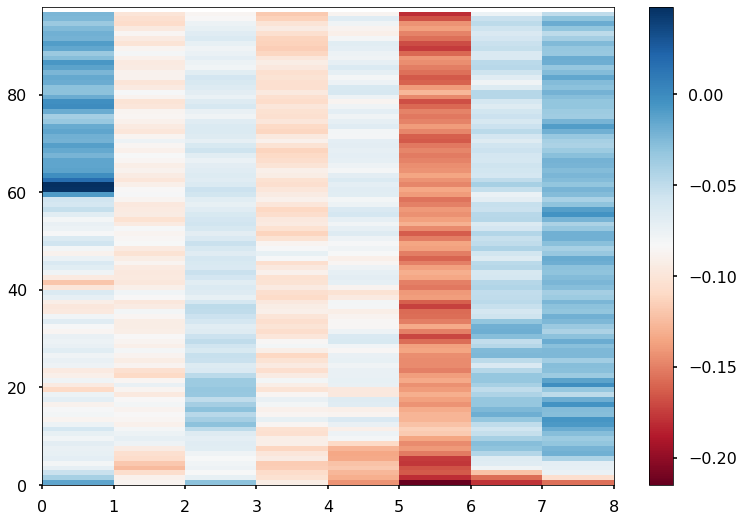

In [78]:
plt.pcolormesh(shear_gridvelu[:,:,2],cmap='RdBu')
plt.colorbar()

In [85]:
transport_gridu = np.empty(gridvelu.shape[2])
transport_gridu[:] = np.NaN
transport_gridv = np.empty(gridvelu.shape[2])
transport_gridv[:] = np.NaN

shear_transport_gridu = np.empty(shear_gridvelu.shape[2])
shear_transport_gridu[:] = np.NaN
shear_transport_gridv = np.empty(shear_gridvelu.shape[2])
shear_transport_gridv[:] = np.NaN



for x in np.arange(0,gridvelu.shape[2]):
    transport_gridu[x] = (np.nansum(gridvelu[:,:,x]*dz*distance))/(10**6) # multiply by 5 because of grid cell size and distance must be the distance of one segment
    transport_gridv[x] = (np.nansum(gridvelv[:,:,x]*dz*distance))/(10**6) # multiply by 5 because of grid cell size
    
    shear_transport_gridu[x] = (np.nansum(shear_gridvelu[:,:,x]*dz*distance))/(10**6) # multiply by 5 because of grid cell size and distance must be the distance of one segment
    shear_transport_gridv[x] = (np.nansum(shear_gridvelv[:,:,x]*dz*distance))/(10**6) # multiply by 5 because of grid cell size
    
    
    

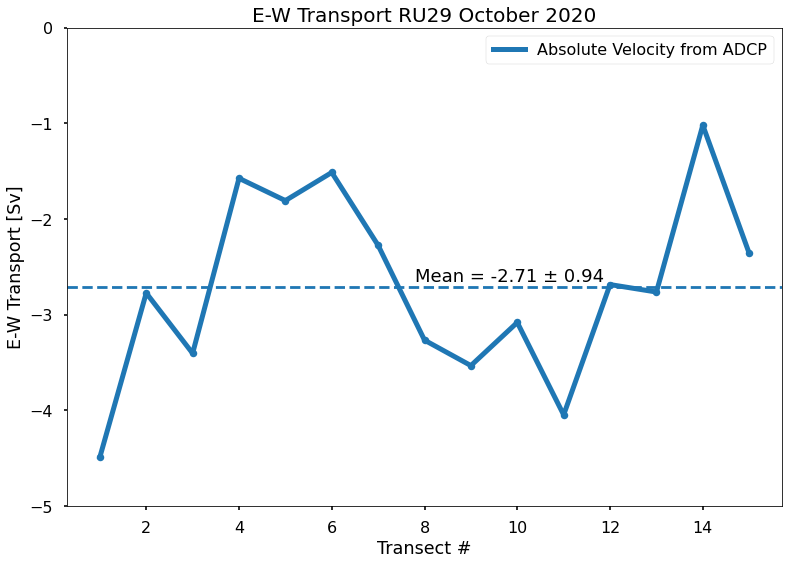

In [89]:
plt.plot(np.arange(1,16),transport_gridu, linewidth=5,color='tab:blue',label='Absolute Velocity from ADCP')
plt.plot(np.arange(1,16),transport_gridu, '.',color='tab:blue',markersize=15)
plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-5,0)
plt.axhline(y=np.nanmean(transport_gridu), color='tab:blue', linestyle='--')
plt.text(7.8, np.nanmean(transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridu),2),np.round(np.nanstd(transport_gridu),2)),fontsize=18);
plt.title('E-W Transport RU29 October 2020',fontsize=20)

plt.legend()


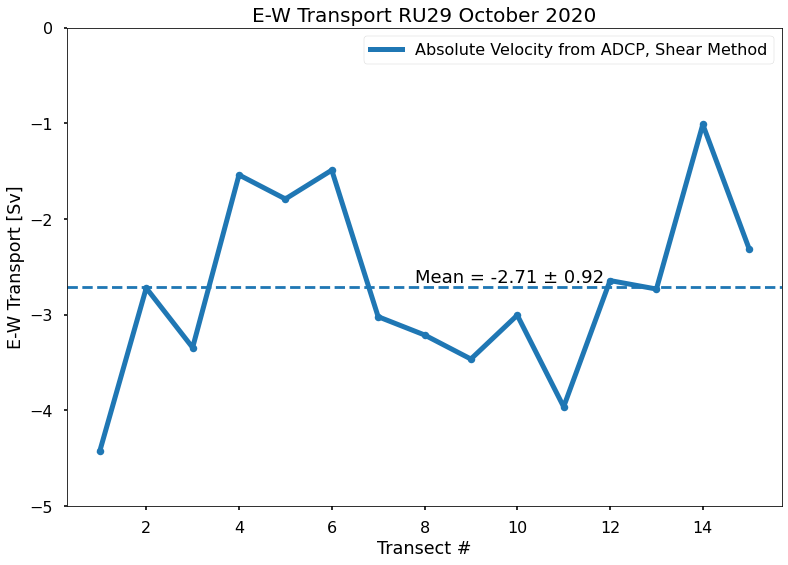

In [90]:
plt.plot(np.arange(1,16),shear_transport_gridu, linewidth=5,color='tab:blue',label='Absolute Velocity from ADCP, Shear Method')
plt.plot(np.arange(1,16),shear_transport_gridu, '.',color='tab:blue',markersize=15)
plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-5,0)
plt.axhline(y=np.nanmean(shear_transport_gridu), color='tab:blue', linestyle='--')
plt.text(7.8, np.nanmean(shear_transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(shear_transport_gridu),2),np.round(np.nanstd(shear_transport_gridu),2)),fontsize=18);
plt.title('E-W Transport RU29 October 2020',fontsize=20)

plt.legend()


## Plot the three methods together

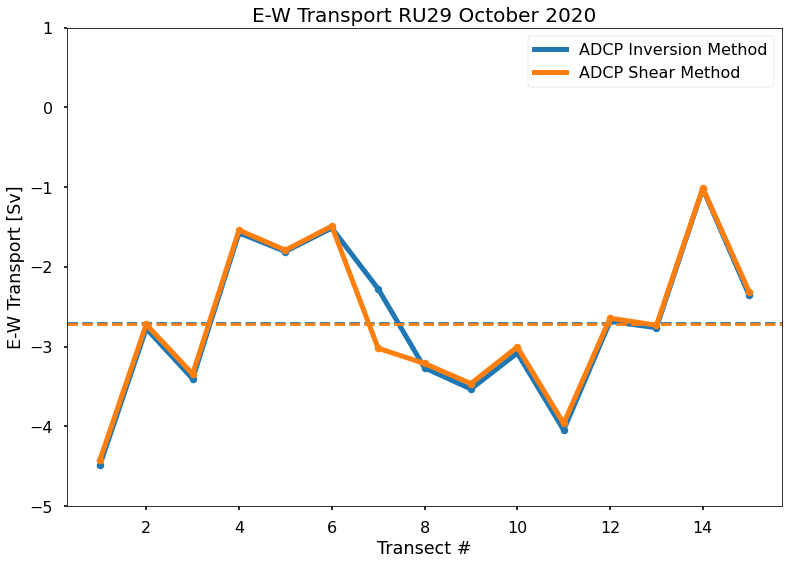

In [92]:
plt.plot(np.arange(1,16),transport_gridu, linewidth=5,color='tab:blue',label='ADCP Inversion Method')
plt.plot(np.arange(1,16),transport_gridu, '.',color='tab:blue',markersize=15)
plt.axhline(y=np.nanmean(transport_gridu), color='tab:blue', linestyle='--')

plt.plot(np.arange(1,16),shear_transport_gridu, linewidth=5,color='tab:orange',label='ADCP Shear Method')
plt.plot(np.arange(1,16),shear_transport_gridu, '.',color='tab:orange',markersize=15)
plt.axhline(y=np.nanmean(shear_transport_gridu), color='tab:orange', linestyle='--')

plt.plot(np.arange(1,16),geo_transport_gridu, linewidth=5,color='tab:grey',label='Geostrophic Velocity from Thermal Wind')
plt.plot(np.arange(1,16),geo_transport_gridu, '.',color='tab:grey',markersize=15)
plt.axhline(y=np.nanmean(geo_transport_gridu), color='tab:grey', linestyle='--')

plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-5,1)
plt.title('E-W Transport RU29 October 2020',fontsize=20)


plt.legend()


Text(0.5, 1.0, 'N-S Transport RU29 October 2020')

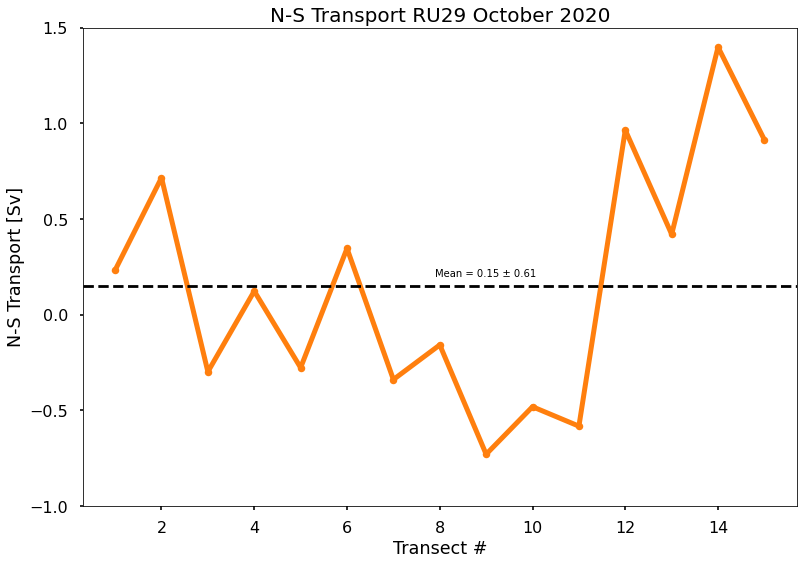

In [93]:
plt.plot(np.arange(1,16),transport_gridv, linewidth=5,color='tab:orange')
plt.plot(np.arange(1,16),transport_gridv, '.',color='tab:orange',markersize=15)
plt.ylabel('N-S Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-1,1.5)
plt.axhline(y=np.nanmean(transport_gridv), color='k', linestyle='--')
plt.text(7.9, np.nanmean(transport_gridv)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridv),2),np.round(np.nanstd(transport_gridv),2)));
plt.title('N-S Transport RU29 October 2020',fontsize=20)
     

Text(0.5, 1.0, 'N-S Transport RU29 October 2020')

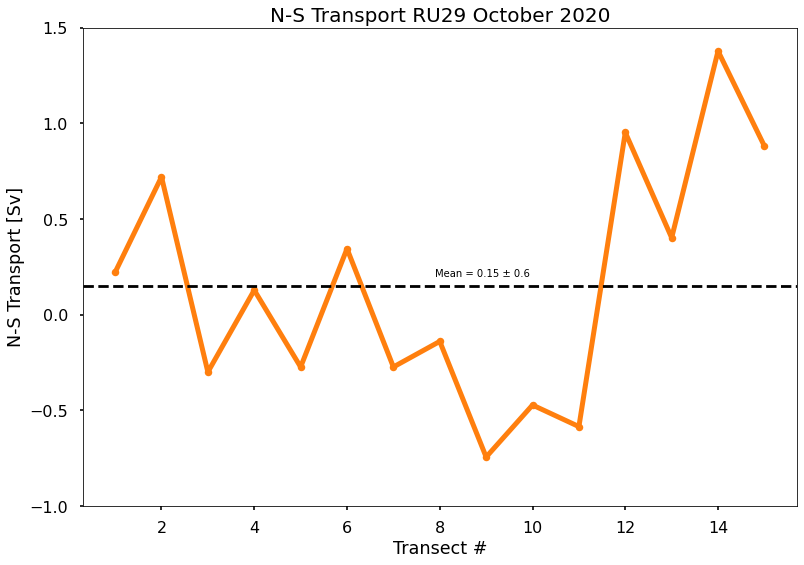

In [94]:
plt.plot(np.arange(1,16),shear_transport_gridv, linewidth=5,color='tab:orange')
plt.plot(np.arange(1,16),shear_transport_gridv, '.',color='tab:orange',markersize=15)
plt.ylabel('N-S Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-1,1.5)
plt.axhline(y=np.nanmean(shear_transport_gridv), color='k', linestyle='--')
plt.text(7.9, np.nanmean(shear_transport_gridv)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(shear_transport_gridv),2),np.round(np.nanstd(shear_transport_gridv),2)));
plt.title('N-S Transport RU29 October 2020',fontsize=20)
     

## Look at just one profile

In [97]:
# x =9
# subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[x], sect_times.endtime.values[x]))

# fig, axs = plt.subplots(1,4, figsize=(30, 15), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# counter = 0
# for x in np.arange(0,12,3):

#     axs[counter].plot(subset_ds_sect.v_grid[:,x], inversion_depth,linewidth=4, color='orange')    
#     axs[counter].fill_betweenx(inversion_depth, 0,subset_ds_sect.v_grid[:,x], alpha=0.3,color='orange')
#     axs[counter].set_xlabel('N-S Velocity [m/s]')
#     axs[counter].set_ylabel('Depth[m]')
#     axs[counter].set_ylim(250,0)
#     axs[counter].set_xticks([-0.2,-0.1,0,0.1,0.2])
#     axs[counter].set_title('End Time: %s' %str(subset_ds_sect.time.values[x])[0:16])
#     counter = counter+1


In [96]:
# x =9
# subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[x], sect_times.endtime.values[x]))

# fig, axs = plt.subplots(1,4, figsize=(30, 15), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# counter = 0
# for x in np.arange(0,12,3):

#     axs[counter].plot(subset_ds_sect.u_grid[:,x], inversion_depth,linewidth=4)    
#     axs[counter].fill_betweenx(inversion_depth, 0,subset_ds_sect.u_grid[:,x], alpha=0.3)
#     axs[counter].set_xlabel('E-W Velocity [m/s]')
#     axs[counter].set_ylabel('Depth[m]')
#     axs[counter].set_ylim(250,0)
#     axs[counter].set_xticks([-0.2,-0.1,0,0.1,0.2])
#     axs[counter].set_title('End Time: %s' %str(subset_ds_sect.time.values[x])[0:16])
#     counter = counter+1



## Plotting for Travis' presentation

In [95]:
## Having a hard time getting this to work because of nans?
#gl_tm, gl_lon, gl_lat, gl_depth, gl_temp = grid_glider_data(gdf, 'temperature', 0.5)
#gl_tm, gl_lon, gl_lat, gl_depth, gl_salinity = grid_glider_data(gdf, 'salinity', 0.5)
#gl_tm, gl_lon, gl_lat, gl_depth, gl_density = grid_glider_data(gdf, 'density', 0.5)


In [260]:
## Remove nans for plotting
nanind = np.where(np.isnan(gdf.depth.values)==False)[0]
gtime  = gdf.time.values[nanind]
gdepth = gdf.depth.values[nanind]
gtemp  = gdf.temperature.values[nanind]

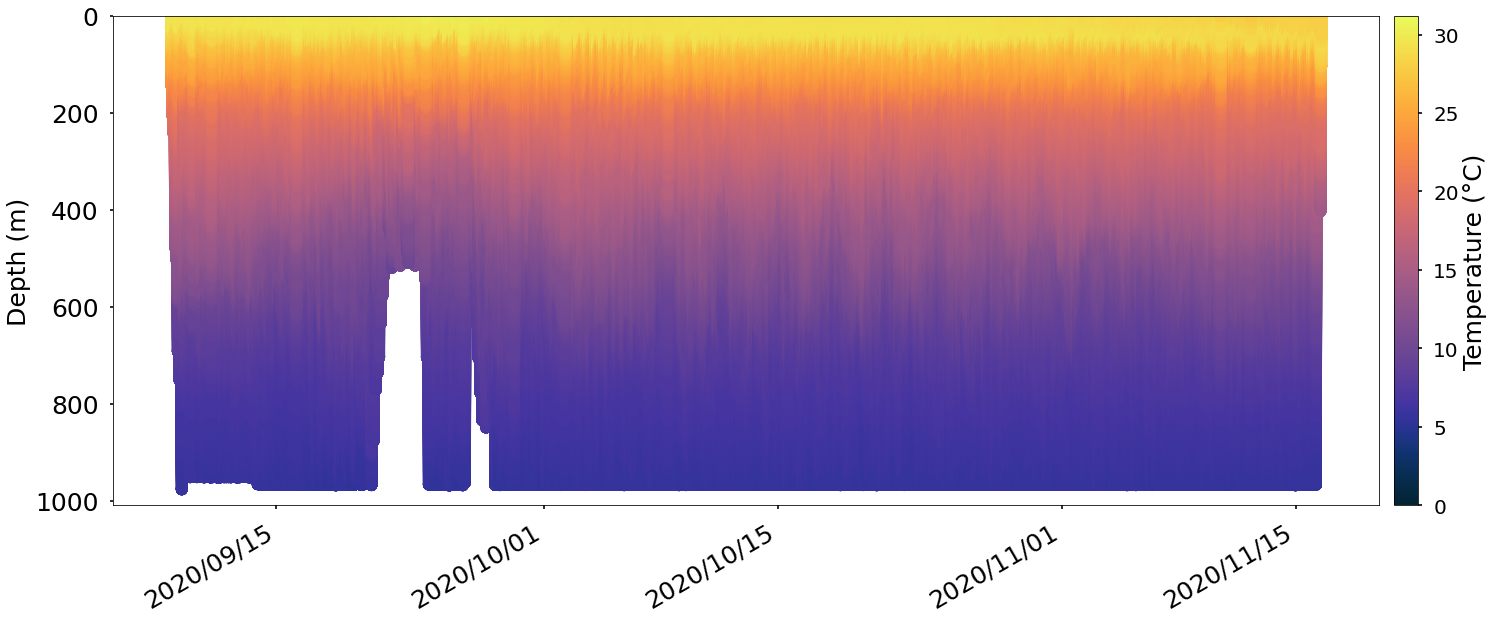

In [261]:
plt.rcParams.update({'font.size': 25})
myFmt = mdates.DateFormatter('%Y/%m/%d')

plt.figure(figsize=(27,10))
plt.scatter(gtime,gdepth,c=gtemp,cmap=cmo.thermal)
cbar = plt.colorbar(pad=0.01)
cbar.set_label(label='Temperature (°C)',size=25)
cbar.ax.tick_params(labelsize=20) 

plt.ylabel('Depth (m)', fontsize = 25)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.ylim(1010,0)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
#plt.xlim(pd.to_datetime(gl_tm2[63]),pd.to_datetime(gl_tm2[140]))
#plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Temperature_Subset.png',dpi=300)

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


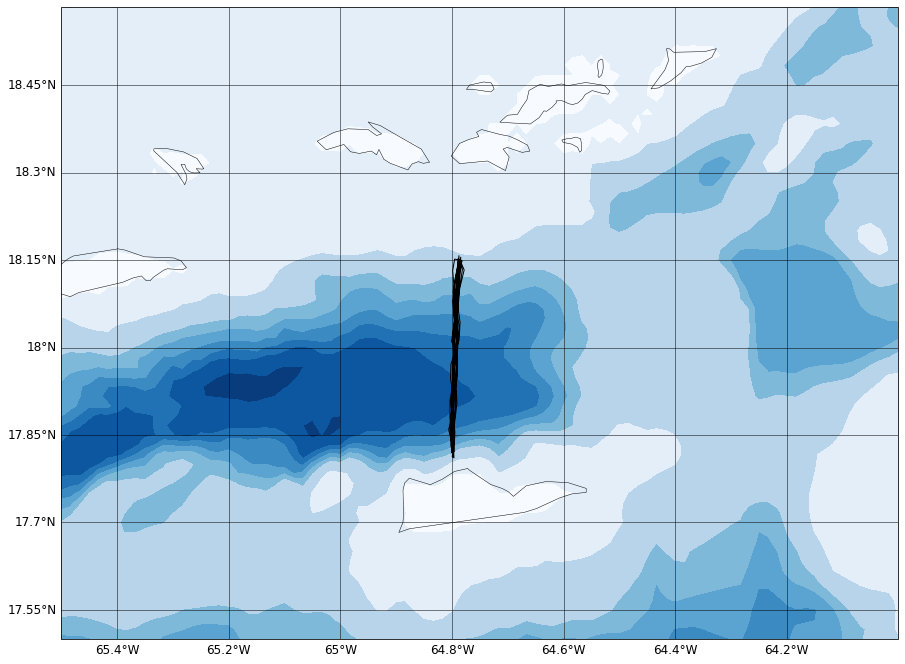

In [253]:
# grab bathymetry data for a map
import cartopy.crs as ccrs

#lat_lims = [16, 19]
#lon_lims = [-66.5, -60.5]
## Zoomed window
lat_lims = [17.5, 18.6]
lon_lims = [-65.5, -64]


# grab some bathymetry
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))

fig = plt.figure(figsize=(15,20))
ax = plt.subplot( projection= ccrs.Mercator())

## Good but too smooth
#dpth_contours = np.arange(-8500, 1, 500)

dpth_contours = np.append(np.arange(-5000, -2000, 500), np.arange(-2000, 1, 1000)) 

#plt.plot(gdf.longitude.values, gdf.latitude.values, 'k',linewidth=6, transform=ccrs.PlateCarree(),color='black')



start = 0
end = -1
gdf_sect = gdf.loc[(gdf.time >= sect_times.starttime.values[start]) & (gdf.time <= sect_times.endtime.values[end])]
subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[start], sect_times.endtime.values[end]))


plt.plot(subset_ds_sect.longitude, subset_ds_sect.latitude,linewidth=1, transform=ccrs.PlateCarree(),color='black')
#plt.plot(gdf_sect.longitude.values, gdf_sect.latitude.values,linewidth=1, transform=ccrs.PlateCarree(),color='red')



plt.contourf(etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours, transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0,extend='both')
#plt.colorbar(label='Depth [m]',pad=0.03, fraction=0.055)
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='black',linewidth=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

#plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Map.png',dpi=300,facecolor='white')

## Mean transect profiles compared to RTOFS now

In [59]:
f = '/home/jg1200/Data/Model/rtofs_20201015_20201017.nc'

rtofs =  xr.open_dataset(f)
rtofs = rtofs.rename({'Longitude': 'lon', 'Latitude': 'lat', 'MT': 'time', 'Depth': 'depth'})
lat = rtofs.lat.data
lon = rtofs.lon.data

extent = [lon_grid[0], lon_grid[0], np.min(lat_grid), np.max(lat_grid)]
# extent = [western_lon, eastern_lon, southern_lat, nothern_lat]
#extent = np.add(extent, [-1, 1, -1, 1]).tolist()
#print(f'Region: {region[0]}, Extent: {extent}')

# interpolating transect X and Y to lat and lon
lonIndex = np.round(np.interp(extent[:2], lon[0, :], np.arange(0, len(lon[0, :])))).astype(int)
latIndex = np.round(np.interp(extent[2:], lat[:, 0], np.arange(0, len(lat[:, 0])))).astype(int)
sub = rtofs.sel(
    X=slice(lonIndex[0], lonIndex[1]),
    Y=slice(latIndex[0], latIndex[1])
)

FileNotFoundError: [Errno 2] No such file or directory: b'/home/jg1200/Data/Model/rtofs_20201015_20201017.nc'

(500.0, -5.0)

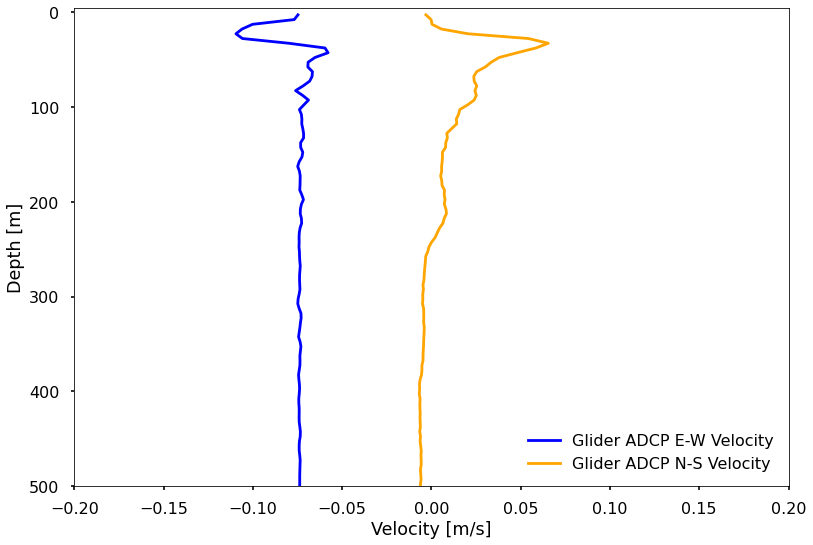

In [256]:

start = 7
end = 7

subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[start], sect_times.endtime.values[end]))


plt.plot(np.mean(subset_ds_sect.u_grid,axis=1), inversion_depth, 'blue',label='Glider ADCP E-W Velocity')
plt.plot(np.mean(subset_ds_sect.v_grid,axis=1), inversion_depth, 'orange',label='Glider ADCP N-S Velocity')

#plt.plot(mean_u,sub.depth.values, 'blue', linestyle='dashed',label='RTOFS E-W Velocity')
#plt.plot(mean_v,sub.depth.values, 'orange', linestyle='dashed',label='RTOFS N-S Velocity')
plt.legend(loc='lower right', frameon=False)
plt.xlabel('Velocity [m/s]')
plt.ylabel('Depth [m]')
plt.xlim(-0.2,0.2)
plt.ylim(500,-5)

In [ ]:
start = 7
end = 7
gdf_sect = gdf.loc[(gdf.time >= sect_times.starttime.values[start]) & (gdf.time <= sect_times.endtime.values[end])]
subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[start], sect_times.endtime.values[end]))


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
#ax4 = ax1.twiny()



lns1 = ax1.plot(np.mean(subset_ds_sect.u_grid,axis=1), subset.depth, 'blue',label='Mean E-W Velocity')
lns2 = ax1.plot(np.mean(subset_ds_sect.v_grid,axis=1), subset.depth, 'orange',label='Mean N-S Velocity')
ax1.set_xlabel('Velocity [m/s]')
ax1.set_ylabel('Depth [m]')
ax1.set_ylim(500,0)
#ax1.set_xticks([-0.15,-0.025,0,0.025,0.05])


#lns3 = ax2.plot(np.nanmean(gl_temp[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, 'k', label = 'Mean Glider Temperature')
#lns4 = ax3.plot(np.nanmean(gl_salinity[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, '--k', label = 'Mean Glider Salinity')
#lns5 = ax4.plot(np.nanmean(gl_density[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, ':k', label = 'Mean Glider Density')


ax2.set_xlim(10,30)
ax2.set_xlabel('Temperature [\N{DEGREE SIGN}C]')
ax3.spines.top.set_position(("axes", 1.15))
ax3.set_xlabel('Salinity [PSU]')
#ax4.spines.top.set_position(("axes", 1.35))
#ax4.set_xlabel('Density [kg/m$^3$]')
#ax4.set_xlim(1021.8,1028)

# added these three lines
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right',frameon=False)